<a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


In [0]:
# Run this before everything
!pip install --upgrade --q tensorflow

In [0]:
from google.colab import drive
import pandas as pd
from pandas import read_csv, to_datetime
import numpy as np
from numpy import array,hstack
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['figure.figsize'] = 10, 5
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime


In [0]:
drive.mount('/content/gdrive')

In [4]:
cd /content/gdrive/My Drive/

/content/gdrive/My Drive


In [0]:
# Import the dataset
drop = ['kVAR', 'kW', 'kWh Value','kVARh Value','kWh Actual', 'Max kW','Period', 'No Of Meters', 'kWh Estimate', 'TOU Demand kW', 'TOU Demand kVA', 'PF', 'CO2']

dataset2018 = read_csv(r'2018_Armidale.csv', header = 0).drop(columns = drop).rename(columns = {"Minimum Temperature": "Temp"}).dropna() # Take into account DST
dataset2019 = read_csv(r'2019_Armidale.csv', header = 0).drop(columns = drop).rename(columns = {"Minimum Temperature": "Temp"}).dropna()
dataset2017 = read_csv(r'2017_Armidale.csv', header = 0).drop(columns = drop).rename(columns = {"Minimum Temperature": "Temp"}).dropna()
datasetAll = pd.concat([dataset2017, dataset2018, dataset2019], axis=0, sort = False, ignore_index= True)

# Scalers for datasetAll.
s_demand = MinMaxScaler()
datasetAll['Demand kVA_s'] =  s_demand.fit_transform(datasetAll[['Demand kVA']])
datasetAll = datasetAll[['Demand kVA_s']].dropna()


In [0]:
datasetAll
su17 = datasetAll.loc[0:5663]
au17 = datasetAll.loc[5664:14495]
wi17 = datasetAll.loc[14496:23327]
sp17 = datasetAll.loc[23328:32059]
su18 = datasetAll.loc[32060:40699]
au18 = datasetAll.loc[40700:49531]
wi18 = datasetAll.loc[49532:58363]
sp18 = datasetAll.loc[58364:67095]
su19 = datasetAll.loc[67096:75735]
au19 = datasetAll.loc[75736: 84567]
wi19 = datasetAll.loc[84568: 93399]
sp19 = datasetAll.loc[93400:102131]
su20 = datasetAll.loc[102132:]

In [7]:
def split_dataset(dataset, fraction = 0.7):
  ## Split the dataset into train and test set ##
  train_size = int(len(dataset) * fraction)
  test_size = len(dataset) - train_size
  train_data, test_data = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  return train_data, test_data

def split_sequence(sequence, n_steps_in, n_steps_out):
	## Split a univariate sequence into samples ##
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import *
print(tensorflow.__version__)

2.1.0


In [0]:
n_steps_in= 60
n_steps_out = 60

# split dataset into train and test set
train, test = split_dataset(su17.append(su18, ignore_index= True).append(su19, ignore_index = True).values,fraction =1)#.append(su19, ignore_index = False).values, fraction = 1)#""".values"""
# split into samples
X_train, y_train = split_sequence(train, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(su20.values, n_steps_in, n_steps_out)

In [0]:
def build_model(X_train, y_train, X_test, y_test, n_steps_in, n_steps_out, epochs, verbose): 
  ## Build an LSTM model ##
    # Define model
    model = Sequential()
    model.add(LSTM(20, activation='relu', return_sequences= 1, input_shape=(n_steps_in, X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(20, return_sequences= 1))
    model.add(Dropout(0.5))
    model.add(LSTM(20, return_sequences = 0))
    #model.add(Dense(600))
    #model.add(Dense({{choice([120, 256, 512, 1024])}}))
    #model.add(LSTM(50, activation='relu', return_sequences= False))
    #model.add(Dropout(0.0001))
    #model.add(LSTM(100, activation='relu', return_sequences= False))
    #model.add(Dense(5))
    #model.add(LSTM(26, activation= 'relu'))
    #model.add(Dropout(0.01))
    model.add(Dense(n_steps_out)) 
    
    # Train Model
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose, validation_split= 0.2, shuffle = False ,callbacks = [EarlyStopping(patience = 10)])
    
    # Visualise Epoch
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()

    return model, history

model, history = build_model(X_train, y_train, X_test, y_test, n_steps_in = n_steps_in, n_steps_out = n_steps_out, epochs = 100, verbose = 2)

In [11]:
def RMSE(model, X_test, y_test, n_steps_out, scaler):
  y_hat = scaler.inverse_transform(model.predict(X_test))
  RMSE = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(y_hat.shape[0], y_hat.shape[1])), y_hat, multioutput= 'raw_values'))
  mean_RMSE = sum(RMSE)/ n_steps_out  
  return y_hat, RMSE, mean_RMSE
y_hat_train, train_RMSE, train_mean_RMSE =RMSE(model, X_train, y_train, n_steps_out, s_demand)
y_hat,RMSE, mean_RMSE = RMSE(model, X_test, y_test, n_steps_out, s_demand)
print("Train")
print(train_RMSE, train_mean_RMSE)
print("Test")
print(RMSE, mean_RMSE)

Train
[16.46753899 17.58389105 18.5251125  19.28406774 19.94371367 20.64283363
 21.3067537  21.96875753 22.63181348 23.07821546 23.53557572 23.87493532
 24.08009721 24.25455875 24.51057008 24.72468968 24.92550161 25.02700778
 25.39558928 25.49718788 25.59324351 25.68362912 25.80797248 25.78916139
 25.83427482 25.74155149 25.90314448 25.68942257 25.78209431 25.59613269
 25.5906336  25.56672505 25.5662142  25.36991056 25.34094771 25.42478208
 25.00853526 25.23399133 25.12910105 25.06169817 24.88289521 24.81124964
 24.75262869 24.74139037 24.59388339 24.78526577 24.596149   24.43045125
 24.55031236 24.36780526 24.45997952 24.38217431 24.5471414  24.39969039
 24.56470639 24.59406715 24.61380468 24.92074995 24.84439686 24.87491525] 24.1780872292923
Test
[12.30878614 12.96161794 13.46768356 13.8209552  14.41526957 14.76839488
 15.24885737 15.70173479 15.97977941 16.49170216 16.65760783 16.94289158
 17.2451271  17.46873908 17.58294587 17.71719093 17.862136   18.15522637
 18.1262987  18.349697

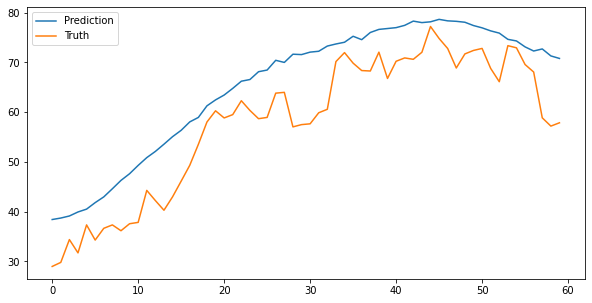

In [44]:
import random
def graphing(y_hat, y_test, scaler):
  i = random.randint(0, y_hat.shape[0])
  plt.plot(y_hat.reshape(y_hat.shape[0],y_hat.shape[1])[i], label = "Prediction")
  plt.plot(scaler.inverse_transform(y_test.reshape(y_hat.shape[0], y_hat.shape[1]))[i], label = "Truth")
  plt.legend()
  plt.show()

graphing(y_hat, y_test, s_demand)
  